#EECS 442 PS6: Image Synthesis

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Your first name] [Your last name], [Your UMich uniqname]

__Important__: after you download the .ipynb file, please name it as __"\<your_uniqname\>_\<your_umid\>.ipynb"__ before you submit it to canvas. Example: PS6_adam.ipynb.



# Starting

Run the following code to import the modules you'll need. After you finish the assignment, remember to run all cells and convert the notebook to a .pdf file for Gradescope submission.

In [ ]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118
Using the GPU!


# Problem 6.1 pix2pix
You will build pix2pix for image translation. The dataloaders for train/test datasets are implemented for you.

In this question, you will need to:

1. Build Generator and Discriminator
2. Train pix2pix and visualize the results during training
3. Plot the loss of generator/discriminator v.s. iteration
4. (Optional) Design your own shoes

## Step 0 Part I: Downloading the dataset.

We first download the `mini-edges2shoes` dataset sampled from the original `edges2shoes` dataset. The `mini-edges2shoes` dataset contains 1,000 training image pairs, and 100 testing image pairs.

There's nothing you need to implement for this part.

In [ ]:
# Download the mini-edges2shoes dataset
!rm -r mini-edges2shoes.zip
!rm -r mini-edges2shoes
!wget http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
!unzip -q mini-edges2shoes.zip

rm: cannot remove 'mini-edges2shoes.zip': No such file or directory
rm: cannot remove 'mini-edges2shoes': No such file or directory
--2023-10-16 23:41:40--  http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48660290 (46M) [application/zip]
Saving to: ‘mini-edges2shoes.zip’

mini-edges2shoes.zi 100%[===================>]  46.41M  66.6MB/s    in 0.7s    

2023-10-16 23:41:41 (66.6 MB/s) - ‘mini-edges2shoes.zip’ saved [48660290/48660290]



## Step 0 Part II: Build dataloaders for train and test

We will first build dataloaders with PyTorch built-in classes. There's nothing you need to implement for this part, but make sure you understand it! This will be helpful for your final projects.

In [ ]:
class Edges2Image(Dataset):
  def __init__(self, root_dir, split='train', transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """

    self.transform = transform
    self.files = glob.glob(os.path.join(root_dir, split, '*.jpg'))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.files[idx])
    img = np.asarray(img)
    if self.transform:
        img = self.transform(img)
    return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# construct the dataloader
train_data = Edges2Image('./mini-edges2shoes', 'train', transform)
test_data = Edges2Image('./mini-edges2shoes', 'val', transform)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

# Make sure that you have 1,000 training images and 100 testing images before moving on
print('Number of training images {}, number of testing images {}'.format(len(train_data), len(test_data)))

Number of training images 1000, number of testing images 100


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


250
20
torch.Size([5, 3, 256, 256])


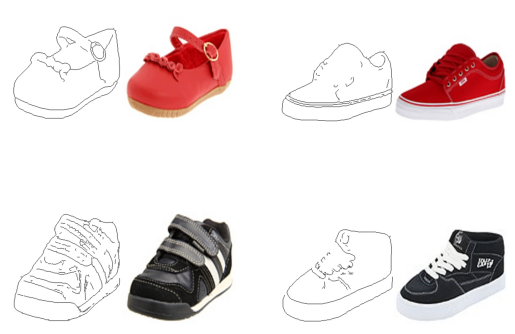

In [ ]:
#Sample Output used for visualization
test = test_loader.__iter__().__next__()
img_size = 256
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  example = std * example + mean
  axes[i].imshow(example)
  axes[i].axis('off')
plt.show()

## Step 1: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

C512-C512-C512-C512-C256-C128-C64-C3

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

We have included a toy example of a U-net architecture below.
Encoder: C64-C128-C256
Decoder: C128-C64-C3

In [ ]:
# (EXAMPLE – Not a part of your solution) Toy example of an U-net architecture
class toy_unet(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    # encoder
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    # decoder
    self.deconv1 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1)
    self.deconv2 = nn.ConvTranspose2d(64 * 2 * 2, 64, 4, 2, 1)
    self.deconv3 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1)

  # forward method
  def forward(self, input):
    # pass through encoder
    e1 = self.conv1(input)
    e2 = self.conv2(F.relu(e1))
    e3 = self.conv3(F.relu(e2))
    # pass through decoder
    d1 = self.deconv1(F.relu(e3))
    d1 = torch.cat([d1, e2], 1) # Concatenation
    d2 = self.deconv2(F.relu(d1))
    d2 = torch.cat([d2, e1], 1) # Concatenation
    d3 = self.deconv3(F.relu(d2))
    return d3

In [ ]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()
    # delete end

In [ ]:
class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    ###########################################################################
    # TODO: Build your Unet generator encoder with the layer sizes            #
    # You can also check the size with the model summary below                #
    ###########################################################################

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    ###########################################################################
    # TODO: Build your Unet generator decoder with the layer sizes            #
    ###########################################################################

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of generator                           #
    ###########################################################################
    # encoding

    # decoding
    # Hint: you can use torch.cat to concatenate the decoder and the encoder inputs

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return output

class discriminator(nn.Module):
  # initializers
  def __init__(self):
    super(discriminator, self).__init__()
    ###########################################################################
    # TODO: Build your CNN discriminator with the layer sizes                 #
    ###########################################################################

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of discriminator                       #
    ###########################################################################

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return x

In [ ]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

In [ ]:
D

In [ ]:
G

**Make sure your model architecturees summary from the above cell match with the given architecture below.**

### generator architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 512, 1, 1]       4,194,816
    ConvTranspose2d-15            [-1, 512, 2, 2]       4,194,816
        BatchNorm2d-16            [-1, 512, 2, 2]           1,024
    ConvTranspose2d-17            [-1, 512, 4, 4]       8,389,120
        BatchNorm2d-18            [-1, 512, 4, 4]           1,024
    ConvTranspose2d-19            [-1, 512, 8, 8]       8,389,120
        BatchNorm2d-20            [-1, 512, 8, 8]           1,024
    ConvTranspose2d-21          [-1, 512, 16, 16]       8,389,120
        BatchNorm2d-22          [-1, 512, 16, 16]           1,024
    ConvTranspose2d-23          [-1, 256, 32, 32]       4,194,560
        BatchNorm2d-24          [-1, 256, 32, 32]             512
    ConvTranspose2d-25          [-1, 128, 64, 64]       1,048,704
        BatchNorm2d-26          [-1, 128, 64, 64]             256
    ConvTranspose2d-27         [-1, 64, 128, 128]         262,208
        BatchNorm2d-28         [-1, 64, 128, 128]             128
    ConvTranspose2d-29          [-1, 3, 256, 256]           6,147
----------------------------------------------------------------
    Total params: 54,419,459
    Trainable params: 54,419,459
    Non-trainable params: 0
----------------------------------------------------------------


### discriminator architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           6,208
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-7          [-1, 512, 31, 31]           1,024
            Conv2d-8            [-1, 1, 30, 30]           8,193
----------------------------------------------------------------
    Total params: 2,769,601
    Trainable params: 2,769,601
    Non-trainable params: 0
----------------------------------------------------------------


## Step 3: Train

In this section, complete the function train.
Then train two model: one with only L1 loss, the other with c=100.



In [ ]:
# Helper function for showing result.
def process_image(img):
  return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
  predict_images = G(x_)

  fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

  for i in range(x_.size()[0]):
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].get_yaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)
    ax[i, 1].get_yaxis().set_visible(False)
    ax[i, 2].get_xaxis().set_visible(False)
    ax[i, 2].get_yaxis().set_visible(False)
    ax[i, 0].cla()
    ax[i, 0].imshow(process_image(x_[i]))
    ax[i, 1].cla()
    ax[i, 1].imshow(process_image(predict_images[i]))
    ax[i, 2].cla()
    ax[i, 2].imshow(process_image(y_[i]))

  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Input'
  fig.text(0.18, 1, label_input, ha='center')
  label_output = 'Output'
  fig.text(0.5, 1, label_output, ha='center')
  label_truth = 'Ground truth'
  fig.text(0.81, 1, label_truth, ha='center')

  plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
  '''
  Counts the number of trainable parameters in PyTorch.
  Args:
      model: PyTorch model.
  Returns:
      num_params: int, number of trainable parameters.
  '''
  num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
  return num_params

In [ ]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
  hist_D_losses = []
  hist_G_losses = []
  hist_G_L1_losses = []
  ###########################################################################
  # TODO: Add Adam optimizer to generator and discriminator                 #
  # You will use lr=0.0002, beta=0.5, beta2=0.999                           #
  ###########################################################################

  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  print('training start!')
  start_time = time.time()
  for epoch in range(num_epochs):
    print('Start training epoch %d' % (epoch + 1))
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for x_ in train_loader:

      y_ = x_[:, :, :, img_size:]
      x_ = x_[:, :, :, 0:img_size]

      x_, y_ = x_.cuda(), y_.cuda()
      ###########################################################################
      # TODO: Implement training code for the discriminator.                    #
      # Recall that the loss is the mean of the loss for real images and fake   #
      # images, and made by some calculations with zeros and ones               #
      # We have defined the BCE_loss, which you might would like to use         #
      ###########################################################################

      ###########################################################################
      #                              END OF YOUR CODE                           #
      ###########################################################################

      # Train the generator
      G.zero_grad()

      G_result = G(x_)
      D_input = torch.cat([x_, G_result], 1)
      D_result = D(D_input).squeeze()

      if only_L1:
        G_train_loss = L1_loss(G_result, y_)
        hist_G_losses.append(L1_loss(G_result, y_).detach().item())
      else:
        G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, y_)
        hist_G_L1_losses.append(L1_loss(G_result, y_).detach().item())
        hist_G_losses.append(BCE_loss(D_result, torch.ones(D_result.size()).cuda()).detach().item())

      G_train_loss.backward()
      G_optimizer.step()
      loss_G = G_train_loss.detach().item()

      D_losses.append(loss_D)
      hist_D_losses.append(loss_D)
      G_losses.append(loss_G)
      num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
    if epoch == 0 or (epoch + 1) % 5 == 0:
      with torch.no_grad():
        show_result(G, fixed_x_, fixed_y_, (epoch+1))

  end_time = time.time()
  total_ptime = end_time - start_time

  return hist_D_losses, hist_G_losses, hist_G_L1_losses

In this part, train your model with only L1 loss with 10 epochs.

In [ ]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

# training
hist_D_L1_losses, hist_G_L1_losses, _ = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

Your generator loss after 10 epochs should be less than 0.15

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir models
torch.save(G_L1.state_dict(), '/content/drive/My Drive/models/G_L1.pth')
torch.save(D_L1.state_dict(), '/content/drive/My Drive/models/D_L1.pth')

In this part, train your model with c=100 with at least 20 epochs.

In [ ]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

In [ ]:
#training, you will be expecting 1-2 minutes per epoch.
# TODO: change_num_epochs if you want
hist_D_100_losses, hist_G_100_BCE_losses, hist_G_100_L1_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [ ]:
torch.save(G_100.state_dict(), '/content/drive/My Drive/models/G_100.pth')
torch.save(D_100.state_dict(), '/content/drive/My Drive/models/D_100.pth')

The following cell saves the trained model parameters to your Google Drive so you could reuse those parameters later without retraining.

### **TODO**: Please comment on the quality of generated images from L1+cGAN and L1 only:

***replace this line with your comment***

Solution: the L1+cGAN images has more details (high frequencies) and color while the L1 only images only have the overall structure (low frequencies) and fewer colors.

## Step 4: Visualization



Please plot the generator BCE and L1 losses, as well as the discriminator loss. For this, please use c=100, and use 3 separate plots.

In [ ]:
###########################################################################
# TODO: Plot the G/D loss history (y axis) vs. Iteration (x axis)         #
# You will have three plots, with hist_D_100_losses,                      #
# hist_G_100_BCE_losses, hist_G_100_L1_losses respectively.               #
# Hiint: Use plt.legend if you want visualize the annotation for your     #
# curve                                                                   #
###########################################################################

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

In this section, plot the G/D loss history vs. Iteration of model with only L1 loss in 2 seperate plots.

In [ ]:
###########################################################################
# TODO: Plot the G/D loss history vs. Iteration in one plot               #
# You will have two plots, with hist_G_L1_losses and hist_D_L1_losses     #
# respectively                                                            #
###########################################################################

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

### **TODO**: Please comment on the loss plots for L1+cGAN and L1 only models:

***replace this line with your comment***

## Step 5: Design Your Shoe

Now you can sketch your dream shoes and let the trained model generate them for you! Try to be creative!

In [ ]:
# @title
# Build a panel that allows sketching in Colab
# Source: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  print('Please sketch below.')
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
      f.write(binary)
  return len(binary)

!mkdir mini-edges2shoes/custom
!apt-get --quiet install imagemagick

In [ ]:
# Press left mouse button and drag your mouse to draw a sketch.
# Then click Finish.
draw(w=256, h=256)
!convert drawing.png drawing.jpg

# save the drawing to dataset folder as a jpg image
img = np.asarray(Image.open('drawing.png'))
img = 255 - img

image.imsave('./mini-edges2shoes/custom/drawing.jpg', np.repeat(img[:,:,3:], 3, axis=2))
custom_dt = Edges2Image('./mini-edges2shoes', 'custom', transform)
custom_loader = DataLoader(custom_dt, batch_size=1, shuffle=False)

Run the following cell to mount your Google Drive. You can retrieve your saved model parameters from your Google Drive.

In [ ]:
# Optional: for loading saved generator
G_100 = generator().cuda()
# For retrieving the model saved to Google Drive
# TODO: add your notebook path
path = None
if path:
  G_100.load_state_dict(torch.load(path + 'models/G_100.pth'))
else:
  G_100.load_state_dict(torch.load('/content/drive/My Drive/models/G_100.pth'))
# For retreiving the model saved on Colab (you just finished training)

G_100.eval()

# process the sketch
for x_ in custom_loader:
  x_ = x_.cuda()[:,:,:,:img_size]
  y_ = G_100(x_)

# visualize the image
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
img_ = process_image(y_[0])
img = process_image(x_[0])
axis[0].imshow(img)
axis[0].axis('off')
axis[1].imshow(img_)
axis[1].axis('off')
plt.show()

# Problem 6.2 style transfer (optional)
__Please Note:__ this problem looks like a lot of code, but you only need to implement two lines. We (442 Staff) wanted to include style transfer, but have slimmed this problem down a lot from previous years.


## Step 0: Downloading the dataset and backbone network.
For this problem, we will use five images as our artistic style, and the Coco validation set as our content image.

A pretrained SqueezeNet will be applied to extract features.

In [ ]:
if os.path.isdir('styles') and os.path.isdir('contents'):
  print('Style images exist')
else:
  print('Downloading images')
  # Download style images
  !wget https://eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip
  !unzip style_images.zip && rm style_images.zip

  # Download content images
  !wget http://images.cocodataset.org/zips/val2017.zip
  !unzip -q val2017.zip && rm val2017.zip
  !mkdir contents
  !mv val2017/* ./contents/

# Download the model
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn = cnn.to(device)

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

## Step 1: Create the image loader and some utility funtions
We provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network. There is nothing to implement here.

In [ ]:
# Dataloader
imsize = 512

SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
                transforms.Resize(imsize),
                transforms.ToTensor(),
                transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
                transforms.Lambda(lambda x: x[None]),
                ])
    image = transform(image)
    return image.to(device, torch.float)

# visualizing the content and style images

style_img = image_loader("styles/muse.jpg", imsize)
content_img = image_loader("contents/000000211825.jpg", imsize)

def deprocess(img):
    # should_rescale true for style transfer
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()
    image = deprocess(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.

    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.

    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = []
    in_feat = x
    for layer in cnn._modules.values():
        out_feat = layer(in_feat)
        feats.append(out_feat)
        in_feat = out_feat
    return feats

## Step 2: Implementing content loss
First, we will implement the *content loss*. This loss encourages the generated image to match the scene structure of the content image. We will implement this loss as the squared $\ell_2$ distance between two convolutional feature maps. Given a feature map of input image $F^x$ and the feature map of content image $F^{c}$, both of shape $(C, H, W)$, the content loss is calculated as follows:

\begin{equation}
\mathcal{L}_c = \sum_{c,i,j}(F^{c}_{c, i, j} - F^{x}_{c, i, j}) ^ 2.
\end{equation}

In [ ]:
def content_loss(f_x, f_con):
    """
    Compute the gram matrix without loop.

    Inputs:
    - f_x: features of the input image with size (1, C, H, W).
    - f_cont: features of the content image with size (1, C, H, W).
    Returns:
    - lc: the content loss
    """

    lc = None

    ###########################################################################
    # TODO: Implement the content loss.                                       #
    # You can check your content loss with some code blocks below             #
    ###########################################################################

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return lc


## Step 3: Implementing style loss
Next, we will implement the *style loss*. This loss encourages the texture of the resulting image to match the input style image. We compute a weighted, squared $\ell_2$ distance between Gram matrices for several layers of the network.

The first step is to calculate the Gram matrix. __This is given__. Given a feature map $F$ of size $(C, H, W)$, the Gram matrix $G \in \mathbb{R}^{C \times C}$ computes the sum of products between channels. The entries $k, l$ of the matrix are computed as:
\begin{equation}
G_{k,l} = \sum_{i,j} F_{k,i,j} F_{l,i,j}.
\end{equation}

The second step is to compare the generated image's Gram matrix with that of the input style image. Define the Gram matrix of input image feature map and style image feature map of at the $l^{th}$ layer as $G^{x,l}$ and $G^{s, l}$, and the weight of the layer as $w^l$. Style loss at the $l^{th}$ layer is
\begin{equation}
L_s^l = w^l \sum_{i,j} (G^{x,l}_{i,j} - G^{s, l}_{i,j})^2,
\end{equation}
where $w^l$ is the weight of layer $l$. The total style loss is a sum over all style layers:
\begin{equation}
    \mathcal{L}_s = \sum_l L_s^l.
\end{equation}
__You need to implement these last two equations. You can do this in one line inside the given loop.__

In [ ]:
def gram_matrix(feat, normalize = True):
    """
    Compute the gram matrix.

    Inputs:
    - feat: a feature tensor of shape (1, C, H, W).
    - normalize: if normalize is true, divide the gram matrix by C*H*W:
    Returns
    - gram: the tram matrix
    """

    gram = None

    B, C, H, W = feat.size()
    feat = feat.view(B, C, H * W)
    gram = torch.bmm(feat, feat.transpose(-2, -1))
    if normalize:
      gram = gram / (H*W*C)

    return gram

In [ ]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.

    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function. The list will contain the features of all layers
      instead of the layers for calcculating style loss
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].

    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """


    ###########################################################################
    # TODO: Implement the style loss                                          #
    ###########################################################################

    loss = 0
    for i in range(len(style_layers)):
      style = gram_matrix(feats[style_layers[i]])
      #your code here

    return loss

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

## Step 4: Network Training
Test out your style transfer!

In [ ]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, init_random = False):
    """
    Run style transfer!

    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - init_random: initialize the starting image to uniform random noise
    """

    # Extract features for the content image
    content_img = image_loader(content_image, image_size)
    feats = get_feature_maps(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = image_loader(style_image, style_size)
    feats = get_feature_maps(style_img, cnn)
    style_targets = []

    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).to(device)
    else:
        img = content_img.clone().to(device)

    # We do want the gradient computed on our image!
    img.requires_grad_()

    # Set up optimization hyperparameters
    initial_lr = 1
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = get_feature_maps(img, cnn)

        # Compute loss
        c_loss = content_loss(feats[content_layer], content_target) * content_weight
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        loss = c_loss + s_loss

        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.figure()
            imshow(img, title='Transferred Image')
            plt.show()
    print('Iteration {}'.format(t))
    plt.figure()
    imshow(img, title='Final transferred Image')


In [ ]:
# Check of content loss. Ignore the style image.
params_content_check = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/muse.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[0, 0, 0, 0],
    'init_random': True
}

style_transfer(**params_content_check)

In [ ]:
# Check of style loss. You should see the texture of the image. Ignore the content image.
params_style_check = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/texture.jpg',
    'image_size':192,
    'style_size':192,
    'content_layer':2,
    'content_weight':0,
    'style_layers':[0, 1],
    'style_weights':[200000, 200000],
    'init_random': True
}

style_transfer(**params_style_check)

In [ ]:
params1 = {
    'content_image':'contents/000000211825.jpg',
    'style_image':'styles/muse.jpg',
    'image_size':192,
    'style_size':512,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params1)

In [ ]:
params2 = {
    'content_image':'contents/000000118515.jpg',
    'style_image':'styles/starry_night.jpg',
    'image_size':192,
    'style_size':192,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params2)

In [ ]:
params3 = {
    'content_image':'contents/000000002157.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
}

style_transfer(**params3)

# Feel free ot change the images and get your own style transferred image

### **TODO**:
Finally, we will try varying the layer used to compute the content loss. Try
different layers l = 0, 1, 2, ..., 12 and report which one provides the best qualitative results.

***replace this line with your answer***

***replace this line with your answer***

Solution: Any number within [0,5] is acceptable.

# Convert Notebook to PDF

In [ ]:
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '/content/drive/' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS 442 Fall 2023 - PS6.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')